# Mathematical optimization: finding minima of functions

In [4]:
import numpy as np

Mathematical optimization deals with the problem of finding numerically minimums (or maximums or zeros) of a function. In this context, the function is called cost function, or objective function, or energy.

Here, we are interested in using `scipy.optimize` for black-box optimization: we do not rely on the mathematical expression of the function that we are optimizing. Note that this expression can often be used for more efficient, non black-box, optimization.

Not all optimization problems are equal. Knowing your problem enables you to choose the right tool.

The scale of an optimization problem is pretty much set by the dimensionality of the problem, i.e. the number of scalar variables on which the search is performed.

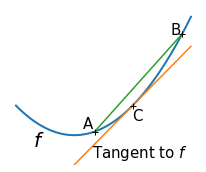

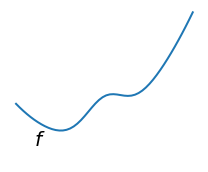

In [7]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1, 2)

plt.figure(1, figsize=(3, 2.5))
plt.clf()

# A convex function
plt.plot(x, x**2, linewidth=2)
plt.text(-.7, -.6**2, '$f$', size=20)

# The tangent in one point
plt.plot(x, 2*x - 1)
plt.plot(1, 1, 'k+')
plt.text(.3, -.75, "Tangent to $f$", size=15)
plt.text(1, 1 - .5, 'C', size=15)

# Convexity as barycenter
plt.plot([.35, 1.85], [.35**2, 1.85**2])
plt.plot([.35, 1.85], [.35**2, 1.85**2], 'k+')
plt.text(.35 - .2, .35**2 + .1, 'A', size=15)
plt.text(1.85 - .2, 1.85**2, 'B', size=15)

plt.ylim(ymin=-1)
plt.axis('off')
plt.tight_layout()

# Convexity as barycenter
plt.figure(2, figsize=(3, 2.5))
plt.clf()
plt.plot(x, x**2 + np.exp(-5*(x - .5)**2), linewidth=2)
plt.text(-.7, -.6**2, '$f$', size=20)

plt.ylim(ymin=-1)
plt.axis('off')
plt.tight_layout()
plt.show()

## 2.7.1.3. Noisy versus exact cost functions

__Noisy gradients__

Many optimization methods rely on gradients of the objective function. If the gradient function is not given, they are computed numerically, which induces errors. In such situation, even if the objective function is not noisy, a gradient-based optimization may be a noisy optimization.

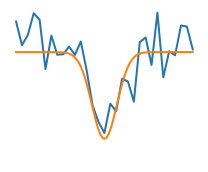

In [9]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

x = np.linspace(-5, 5, 101)
x_ = np.linspace(-5, 5, 31)

def f(x):
    return -np.exp(-x**2)

# A smooth function
plt.figure(1, figsize=(3, 2.5))
plt.clf()

plt.plot(x_, f(x_) + .2*np.random.normal(size=31), linewidth=2)
plt.plot(x, f(x), linewidth=2)

plt.ylim(ymin=-1.3)
plt.axis('off')
plt.tight_layout()
plt.show()

## 2.7.2. A review of the different optimizers
## 2.7.2.1. Getting started: 1D optimization


Let’s get started by finding the minimum of the scalar function

$$f(x)=\exp[(x-0.7)^2] $$

`scipy.optimize.minimize_scalar()` uses Brent’s method to find the minimum of a function

In [5]:
from scipy import optimize

def f(x):
    return -np.exp(-(x - 0.7) ** 2)

result = optimize.minimize_scalar(f)
result.success

True

In [6]:
x_min = result.x
x_min

0.6999999997839409

Converged at  6
Converged at  23


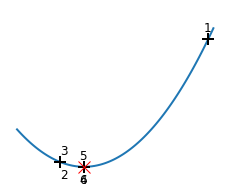

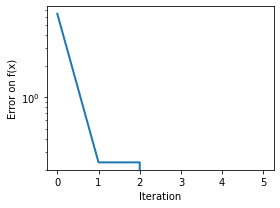

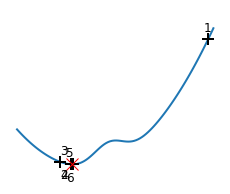

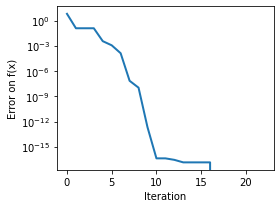

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

x = np.linspace(-1, 3, 100)
x_0 = np.exp(-1)

def f(x):
    return (x - x_0)**2 + epsilon*np.exp(-5*(x - .5 - x_0)**2)

for epsilon in (0, 1):
    plt.figure(figsize=(3, 2.5))
    plt.axes([0, 0, 1, 1])

    # A convex function
    plt.plot(x, f(x), linewidth=2)

    # Apply brent method. To have access to the iteration, do this in an
    # artificial way: allow the algorithm to iter only once
    all_x = list()
    all_y = list()
    for iter in range(30):
        result = optimize.minimize_scalar(f, bracket=(-5, 2.9, 4.5), method="Brent",
                    options={"maxiter": iter}, tol=np.finfo(1.).eps)
        if result.success:
            print('Converged at ', iter)
            break

        this_x = result.x
        all_x.append(this_x)
        all_y.append(f(this_x))
        if iter < 6:
            plt.text(this_x - .05*np.sign(this_x) - .05,
                    f(this_x) + 1.2*(.3 - iter % 2), iter + 1,
                    size=12)

    plt.plot(all_x[:10], all_y[:10], 'k+', markersize=12, markeredgewidth=2)

    plt.plot(all_x[-1], all_y[-1], 'rx', markersize=12)
    plt.axis('off')
    plt.ylim(ymin=-1, ymax=8)

    plt.figure(figsize=(4, 3))
    plt.semilogy(np.abs(all_y - all_y[-1]), linewidth=2)
    plt.ylabel('Error on f(x)')
    plt.xlabel('Iteration')
    plt.tight_layout()

plt.show()

## 2.7.2.2. Gradient based methods

Gradient descent basically consists in taking small steps in the direction of the gradient, that is the direction of the steepest descent.

The core problem of gradient-methods on ill-conditioned problems is that the gradient tends not to point in the direction of the minimum.

Very anisotropic (ill-conditioned) functions are harder to optimize.
The more a function looks like a quadratic function (elliptic iso-curves), the easier it is to optimize.

An example demoing gradient descent by creating figures that trace the evolution of the optimizer.

scipy provides `scipy.optimize.minimize()` to find the minimum of scalar functions of one or more variables. The simple conjugate gradient method can be used by setting the parameter method to `CG`

In [10]:
def f(x):
    # rosenbrock function
    return .5*(1 - x[0])**2 + (x[1] - x[0]**2)**2

In [12]:
optimize.minimize(f, [2, -1], method='CG')

     fun: 1.6486281937428067e-11
     jac: array([-6.15024682e-06,  2.53707854e-07])
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 13
    njev: 27
  status: 0
 success: True
       x: array([0.99999426, 0.99998864])

Gradient methods need the Jacobian (gradient) of the function. They can compute it numerically, but will perform better if you can pass them the gradient:

In [13]:
def jacobian(x):
    return np.array((-2*.5*(1 - x[0]) - 4*x[0]*(x[1] - x[0]**2), 2*(x[1] - x[0]**2)))

In [14]:
optimize.minimize(f, [2, 1], method='CG', jac=jacobian)

     fun: 2.957865890641887e-14
     jac: array([ 7.18259502e-07, -2.99030306e-07])
 message: 'Optimization terminated successfully.'
    nfev: 16
     nit: 8
    njev: 16
  status: 0
 success: True
       x: array([1.00000012, 1.00000009])

## 2.7.2.3. Newton and quasi-newton methods
Newton methods use a local quadratic approximation to compute the jump direction. For this purpose, they rely on the 2 first derivative of the function: the gradient and the Hessian.

In scipy, you can use the Newton method by setting method to Newton-CG in scipy.optimize.minimize(). Here, CG refers to the fact that an internal inversion of the Hessian is performed by conjugate gradient

In [15]:
def f(x):
    # rosenbrock function
    return .5*(1 - x[0])**2 + (x[1] - x[0]**2)**2

def jacobian(x):
    return np.array((-2*.5*(1 - x[0]) - 4*x[0]*(x[1] - x[0]**2), 2*(x[1] - x[0]**2)))

In [16]:
optimize.minimize(f, [2, -1], method='Newton-CG', jac=jacobian)

     fun: 1.5601357400786612e-15
     jac: array([ 1.05753092e-07, -7.48325277e-08])
 message: 'Optimization terminated successfully.'
    nfev: 11
    nhev: 0
     nit: 10
    njev: 33
  status: 0
 success: True
       x: array([0.99999995, 0.99999988])

Note that compared to a conjugate gradient (above), Newton’s method has required less function evaluations, but more gradient evaluations, as it uses it to approximate the Hessian. Let’s compute the Hessian and pass it to the algorithm:

In [17]:
def hessian(x):
    return np.array(((1 - 4*x[1] + 12*x[0]**2, -4*x[0]), (-4*x[0], 2)))

optimize.minimize(f, [2, -1], method='Newton-CG', jac=jacobian, hess=hessian)

     fun: 1.6277298383706738e-15
     jac: array([ 1.11044158e-07, -7.78093352e-08])
 message: 'Optimization terminated successfully.'
    nfev: 11
    nhev: 10
     nit: 10
    njev: 11
  status: 0
 success: True
       x: array([0.99999994, 0.99999988])

__Note__

At very high-dimension, the inversion of the Hessian can be costly and unstable (large scale > 250). 

Newton optimizers should not to be confused with Newton’s root finding method, based on the same principles, `scipy.optimize.newton()`.

## Quasi-Newton methods: approximating the Hessian on the fly

BFGS: BFGS (Broyden-Fletcher-Goldfarb-Shanno algorithm) refines at each step an approximation of the Hessian.